In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import mahotas as mh
import json

In [3]:
import cactas as C

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'

In [5]:
with open("image_data_v3.json", "r") as fp:
    image_data = json.load(fp)
with open("label_data_v3.json", "r") as fp:
    label_data = json.load(fp)

In [6]:
with open(DATAPATH+'../ESUS_stroke_side.csv', 'r') as f:
    stroke_sides = f.read().replace('ESUS ','').split('\n')

STROKE_SIDES = {}
    
for l in stroke_sides[1:]:
    l_s = l.split(',')
    
    if len(l_s) != 5:
        continue
    
    id_ = l_s[0]
    age = l_s[1]
    sex = l_s[2]
    race = l_s[3]
    side = l_s[4]
    STROKE_SIDES[id_] = side

In [7]:
images, labels = C.Util.load(DATAPATH)

In [8]:
for key, val in image_data.items():
    stroke_side = STROKE_SIDES[key]
    print('file name', key)
    print('Stroke side', stroke_side)

file name 2
Stroke side R
file name 5
Stroke side R
file name 6
Stroke side L
file name 7
Stroke side L
file name 9
Stroke side R
file name 10
Stroke side L
file name 12
Stroke side L
file name 13
Stroke side L
file name 14
Stroke side L
file name 15
Stroke side L
file name 16
Stroke side L
file name 17
Stroke side R
file name 18
Stroke side L
file name 21
Stroke side R
file name 22
Stroke side L
file name 23
Stroke side L
file name 24
Stroke side R
file name 25
Stroke side L
file name 26
Stroke side R
file name 27
Stroke side R
file name 29
Stroke side R
file name 31
Stroke side L
file name 32
Stroke side R
file name 33
Stroke side R
file name 35
Stroke side L
file name 36
Stroke side R
file name 39
Stroke side L
file name 40
Stroke side R
file name 41
Stroke side R
file name 45
Stroke side L
file name 46
Stroke side R
file name 47
Stroke side L
file name 48
Stroke side L
file name 49
Stroke side R
file name 50
Stroke side R
file name 51
Stroke side L
file name 52
Stroke side R
file n

In [9]:
# normalize grayscale to 0..1
images, labels = C.Util.normalize(images, labels)

# for each scan
symp_i_patches = []
symp_l_patches = []
asymp_i_patches = []
asymp_l_patches = []

P=64

In [10]:
images.shape

(766, 512, 512, 1)

In [11]:
labels.shape

(766, 512, 512, 1)

In [54]:
# loop thru each slice
n = 0
for i in range(labels.shape[0]):
    #print(labels[i].shape)
    bbox = mh.bbox(labels[i])
    
    #print(bbox)

    location = ''
    if (512 - bbox[0] < 256):
        location = 'L' # patient view
    else:
        location = 'R' # patient view
        
    increase_x = 10
    increase_y = 10
    increase_z = 0
    target_size = P
    
    
    if target_size:
        widthY = bbox[1]-bbox[0]
        widthX = bbox[3]-bbox[2]
        #print(widthY)
        #print(widthX)

        increase_x = (target_size - widthX) // 2
        increase_y = (target_size - widthY) // 2
        
        print(bbox)
        print(widthY, widthX, increase_x, increase_y)

        bufferY = 0
        if (bbox[0]-increase_y + bbox[1]+increase_y) != target_size:
            bufferY = 1

        bufferX = 0
        if (bbox[2]-increase_x + bbox[3]+increase_x) != target_size:
            bufferX = 1
            
    # crop label and image according to bbox but make it a little larger
    label_cropped = labels[i][bbox[0]-increase_y:bbox[1]+increase_y+bufferY,
                           #bbox[0]-increase_y:bbox[1]+increase_y+bufferY,
                           bbox[2]-increase_x:bbox[3]+increase_x+bufferX]
    image_cropped = images[i][bbox[0]-increase_y:bbox[1]+increase_y+bufferY,
                           #bbox[0]-increase_y:bbox[1]+increase_y+bufferY,
                           bbox[2]-increase_x:bbox[3]+increase_x+bufferX]


    if location == stroke_side:
        symp_i_patches.append(image_cropped)
        symp_l_patches.append(label_cropped)
    else:
        asymp_i_patches.append(image_cropped)
        asymp_l_patches.append(label_cropped)
    n += 1
    print(n)

    print(image_cropped.shape)
    print(label_cropped.shape)

[293 297 194 200   0   1]
4 6 29 30
1
(65, 65, 1)
(65, 65, 1)
[201 300 193 212   0   1]
99 19 22 -18
2
(64, 64, 1)
(64, 64, 1)
[202 300 195 210   0   1]
98 15 24 -17
3
(65, 64, 1)
(65, 64, 1)
[196 205 208 221   0   1]
9 13 25 27
4
(64, 64, 1)
(64, 64, 1)
[195 199 217 223   0   1]
4 6 29 30
5
(65, 65, 1)
(65, 65, 1)
[195 198 219 223   0   1]
3 4 30 30
6
(64, 65, 1)
(64, 65, 1)
[186 189 218 222   0   1]
3 4 30 30
7
(64, 65, 1)
(64, 65, 1)
[186 191 215 222   0   1]
5 7 28 29
8
(64, 64, 1)
(64, 64, 1)
[186 191 217 223   0   1]
5 6 29 29
9
(64, 65, 1)
(64, 65, 1)
[188 189 222 223   0   1]
1 1 31 31
10
(64, 64, 1)
(64, 64, 1)
[278 281 263 268   0   1]
3 5 29 30
11
(64, 64, 1)
(64, 64, 1)
[265 281 264 276   0   1]
16 12 26 24
12
(65, 65, 1)
(65, 65, 1)
[265 274 273 276   0   1]
9 3 30 27
13
(64, 64, 1)
(64, 64, 1)
[265 270 268 273   0   1]
5 5 29 29
14
(64, 64, 1)
(64, 64, 1)
[265 270 266 273   0   1]
5 7 28 29
15
(64, 64, 1)
(64, 64, 1)
[266 271 266 272   0   1]
5 6 29 29
16
(64, 65, 1)
(64,

142
(64, 64, 1)
(64, 64, 1)
[200 325 234 259   0   1]
125 25 19 -31
143
(64, 64, 1)
(64, 64, 1)
[198 324 235 259   0   1]
126 24 20 -31
144
(65, 65, 1)
(65, 65, 1)
[200 208 252 257   0   1]
8 5 29 28
145
(65, 64, 1)
(65, 64, 1)
[204 205 254 255   0   1]
1 1 31 31
146
(64, 64, 1)
(64, 64, 1)
[309 316 223 228   0   1]
7 5 29 28
147
(64, 64, 1)
(64, 64, 1)
[309 316 223 229   0   1]
7 6 29 28
148
(64, 65, 1)
(64, 65, 1)
[310 313 224 228   0   1]
3 4 30 30
149
(64, 65, 1)
(64, 65, 1)
[198 200 220 222   0   1]
2 2 31 31
150
(65, 65, 1)
(65, 65, 1)
[197 206 214 223   0   1]
9 9 27 27
151
(64, 64, 1)
(64, 64, 1)
[197 207 213 223   0   1]
10 10 27 27
152
(65, 65, 1)
(65, 65, 1)
[196 208 214 224   0   1]
12 10 27 26
153
(65, 65, 1)
(65, 65, 1)
[196 208 215 224   0   1]
12 9 27 26
154
(65, 64, 1)
(65, 64, 1)
[202 207 218 225   0   1]
5 7 28 29
155
(64, 64, 1)
(64, 64, 1)
[197 198 222 223   0   1]
1 1 31 31
156
(64, 64, 1)
(64, 64, 1)
[196 198 221 224   0   1]
2 3 30 31
157
(65, 64, 1)
(65, 64, 1)

[311 328 237 252   0   1]
17 15 24 23
284
(64, 64, 1)
(64, 64, 1)
[310 319 237 248   0   1]
9 11 26 27
285
(64, 64, 1)
(64, 64, 1)
[310 322 237 247   0   1]
12 10 27 26
286
(65, 65, 1)
(65, 65, 1)
[309 323 237 257   0   1]
14 20 22 25
287
(65, 65, 1)
(65, 65, 1)
[307 319 240 256   0   1]
12 16 24 26
288
(65, 65, 1)
(65, 65, 1)
[306 319 244 255   0   1]
13 11 26 25
289
(64, 64, 1)
(64, 64, 1)
[305 320 245 257   0   1]
15 12 26 24
290
(64, 65, 1)
(64, 65, 1)
[223 315 203 256   0   1]
92 53 5 -14
291
(65, 64, 1)
(65, 64, 1)
[222 311 203 252   0   1]
89 49 7 -13
292
(64, 64, 1)
(64, 64, 1)
[222 242 206 223   0   1]
20 17 23 22
293
(65, 64, 1)
(65, 64, 1)
[222 310 205 251   0   1]
88 46 9 -12
294
(65, 65, 1)
(65, 65, 1)
[228 242 207 222   0   1]
14 15 24 25
295
(65, 64, 1)
(65, 64, 1)
[230 245 207 221   0   1]
15 14 25 24
296
(64, 65, 1)
(64, 65, 1)
[239 247 209 218   0   1]
8 9 27 28
297
(65, 64, 1)
(65, 64, 1)
[238 249 207 219   0   1]
11 12 26 26
298
(64, 65, 1)
(64, 65, 1)
[231 249 208 

[169 190 243 257   0   1]
21 14 25 21
426
(64, 65, 1)
(64, 65, 1)
[168 330 231 259   0   1]
162 28 18 -49
427
(65, 65, 1)
(65, 65, 1)
[166 333 232 261   0   1]
167 29 17 -52
428
(64, 64, 1)
(64, 64, 1)
[166 329 232 261   0   1]
163 29 17 -50
429
(64, 64, 1)
(64, 64, 1)
[170 308 233 259   0   1]
138 26 19 -37
430
(65, 65, 1)
(65, 65, 1)
[174 307 237 255   0   1]
133 18 23 -35
431
(64, 65, 1)
(64, 65, 1)
[180 308 239 253   0   1]
128 14 25 -32
432
(65, 65, 1)
(65, 65, 1)
[309 313 245 247   0   1]
4 2 31 30
433
(65, 65, 1)
(65, 65, 1)
[308 316 244 249   0   1]
8 5 29 28
434
(65, 64, 1)
(65, 64, 1)
[308 315 244 249   0   1]
7 5 29 28
435
(64, 64, 1)
(64, 64, 1)
[309 316 244 249   0   1]
7 5 29 28
436
(64, 64, 1)
(64, 64, 1)
[240 316 244 251   0   1]
76 7 28 -6
437
(65, 64, 1)
(65, 64, 1)
[239 318 245 251   0   1]
79 6 29 -8
438
(64, 65, 1)
(64, 65, 1)
[238 319 246 261   0   1]
81 15 24 -9
439
(64, 64, 1)
(64, 64, 1)
[239 310 245 261   0   1]
71 16 24 -4
440
(64, 65, 1)
(64, 65, 1)
[240 311

[333 335 257 262   0   1]
2 5 29 31
568
(65, 64, 1)
(65, 64, 1)
[177 186 270 277   0   1]
9 7 28 27
569
(64, 64, 1)
(64, 64, 1)
[176 186 271 278   0   1]
10 7 28 27
570
(65, 64, 1)
(65, 64, 1)
[176 184 272 280   0   1]
8 8 28 28
571
(65, 65, 1)
(65, 65, 1)
[177 182 274 279   0   1]
5 5 29 29
572
(64, 64, 1)
(64, 64, 1)
[173 325 279 298   0   1]
152 19 22 -44
573
(65, 64, 1)
(65, 64, 1)
[172 326 279 298   0   1]
154 19 22 -45
574
(65, 64, 1)
(65, 64, 1)
[173 181 279 284   0   1]
8 5 29 28
575
(65, 64, 1)
(65, 64, 1)
[173 178 283 284   0   1]
5 1 31 29
576
(64, 64, 1)
(64, 64, 1)
[344 354 287 301   0   1]
10 14 25 27
577
(65, 65, 1)
(65, 65, 1)
[344 356 287 300   0   1]
12 13 25 26
578
(65, 64, 1)
(65, 64, 1)
[346 351 297 300   0   1]
5 3 30 29
579
(64, 64, 1)
(64, 64, 1)
[185 186 321 322   0   1]
1 1 31 31
580
(64, 64, 1)
(64, 64, 1)
[183 291 307 328   0   1]
108 21 21 -22
581
(65, 64, 1)
(65, 64, 1)
[184 291 304 328   0   1]
107 24 20 -22
582
(64, 65, 1)
(64, 65, 1)
[191 290 303 327   

[203 304 250 275   0   1]
101 25 19 -19
710
(64, 64, 1)
(64, 64, 1)
[202 305 248 274   0   1]
103 26 19 -20
711
(64, 65, 1)
(64, 65, 1)
[203 305 247 272   0   1]
102 25 19 -19
712
(65, 64, 1)
(65, 64, 1)
[203 304 245 270   0   1]
101 25 19 -19
713
(64, 64, 1)
(64, 64, 1)
[203 303 244 268   0   1]
100 24 20 -18
714
(65, 65, 1)
(65, 65, 1)
[202 302 242 267   0   1]
100 25 19 -18
715
(65, 64, 1)
(65, 64, 1)
[202 302 241 266   0   1]
100 25 19 -18
716
(65, 64, 1)
(65, 64, 1)
[201 302 241 266   0   1]
101 25 19 -19
717
(64, 64, 1)
(64, 64, 1)
[201 301 239 264   0   1]
100 25 19 -18
718
(65, 64, 1)
(65, 64, 1)
[201 303 238 263   0   1]
102 25 19 -19
719
(65, 64, 1)
(65, 64, 1)
[201 302 237 262   0   1]
101 25 19 -19
720
(64, 64, 1)
(64, 64, 1)
[202 301 246 261   0   1]
99 15 24 -18
721
(64, 64, 1)
(64, 64, 1)
[202 299 245 259   0   1]
97 14 25 -17
722
(64, 65, 1)
(64, 65, 1)
[202 296 244 257   0   1]
94 13 25 -15
723
(65, 64, 1)
(65, 64, 1)
[203 295 244 255   0   1]
92 11 26 -14
724
(65, 64,

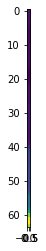

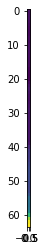

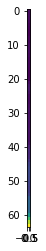

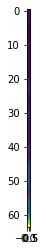

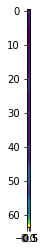

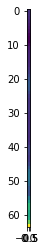

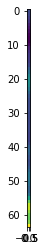

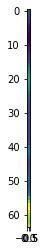

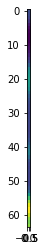

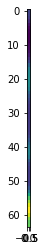

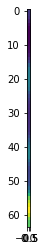

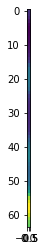

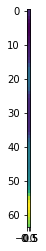

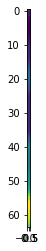

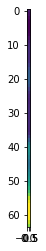

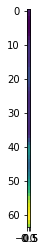

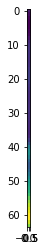

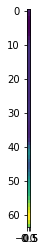

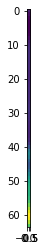

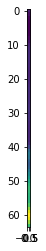

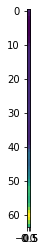

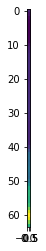

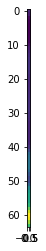

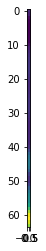

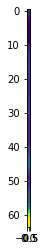

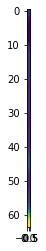

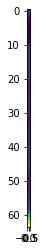

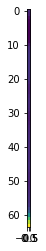

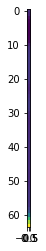

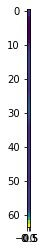

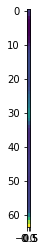

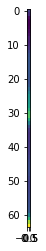

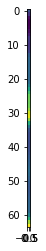

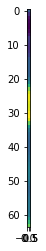

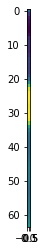

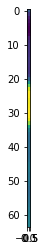

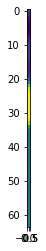

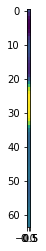

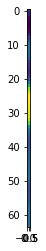

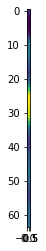

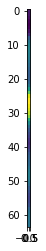

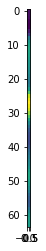

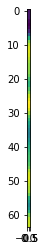

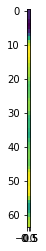

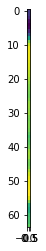

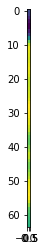

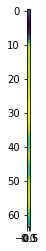

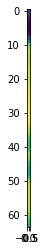

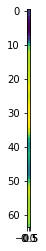

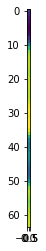

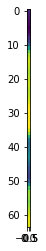

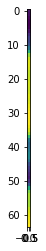

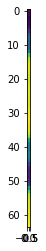

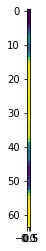

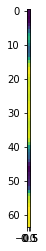

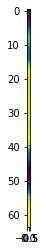

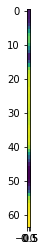

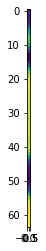

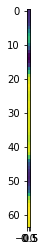

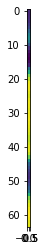

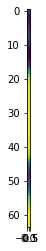

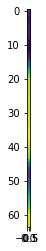

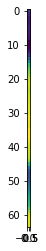

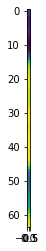

In [55]:
for i in range(len(image_cropped)):
    plt.imshow(image_cropped[i])
    plt.show()

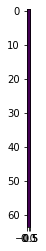

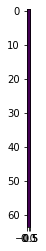

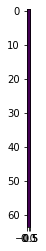

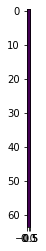

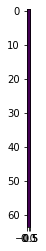

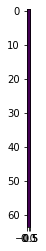

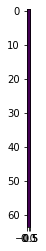

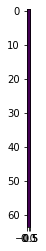

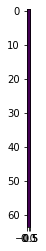

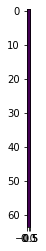

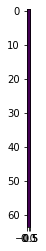

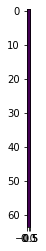

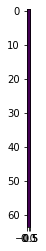

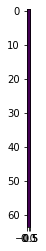

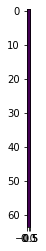

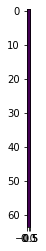

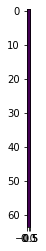

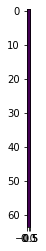

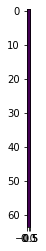

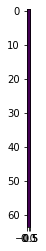

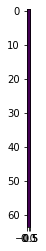

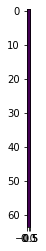

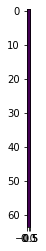

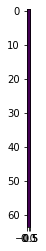

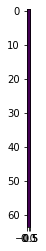

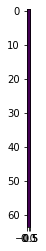

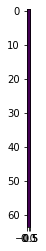

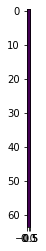

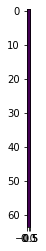

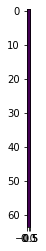

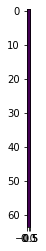

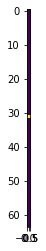

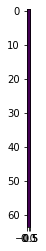

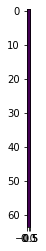

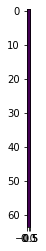

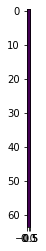

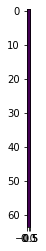

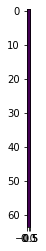

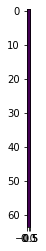

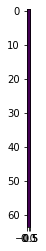

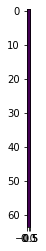

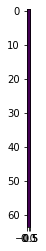

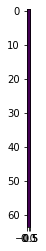

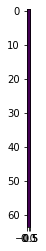

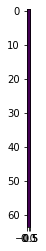

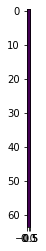

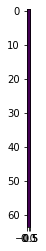

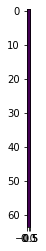

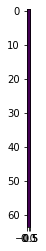

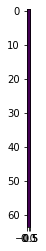

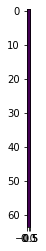

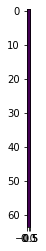

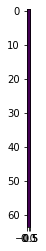

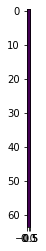

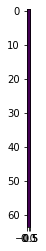

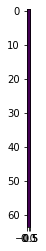

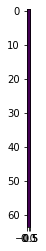

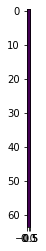

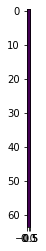

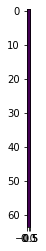

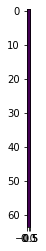

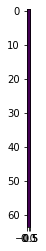

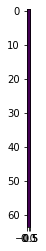

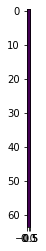

In [56]:
for i in range(len(label_cropped)):
    plt.imshow(label_cropped[i])
    plt.show()

In [57]:
len(label_cropped)

64